In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import mean_absolute_percentage_error
import math

In [80]:
# datasets chosen - tech companies
df_aapl = pd.read_csv('../datasets/stocks/AAPL.csv')
df_ggl = pd.read_csv('../datasets/stocks/GOOGL.csv')
df_msft = pd.read_csv('../datasets/stocks/MSFT.csv')

Text(0, 0.5, 'Close Price')

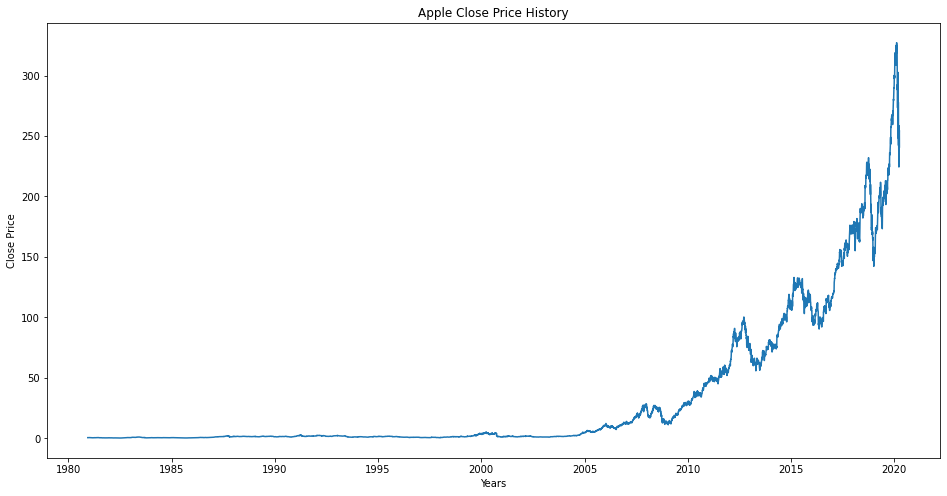

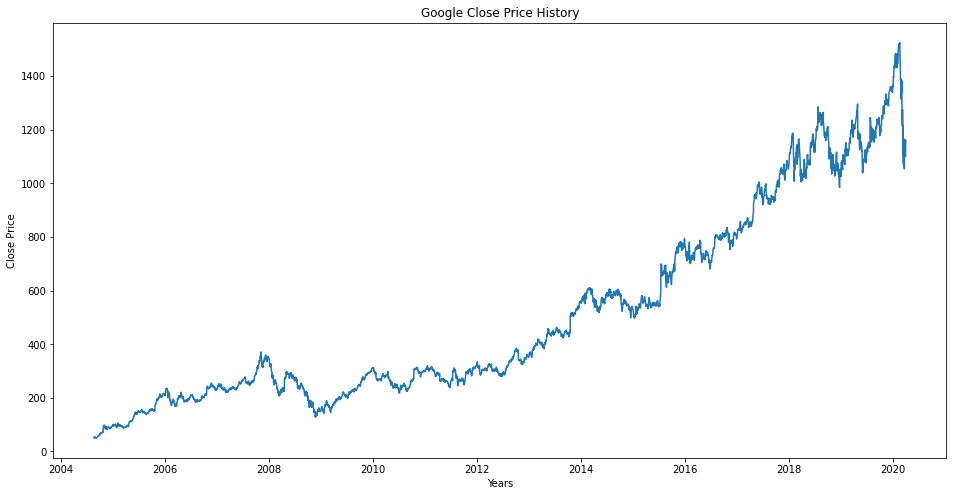

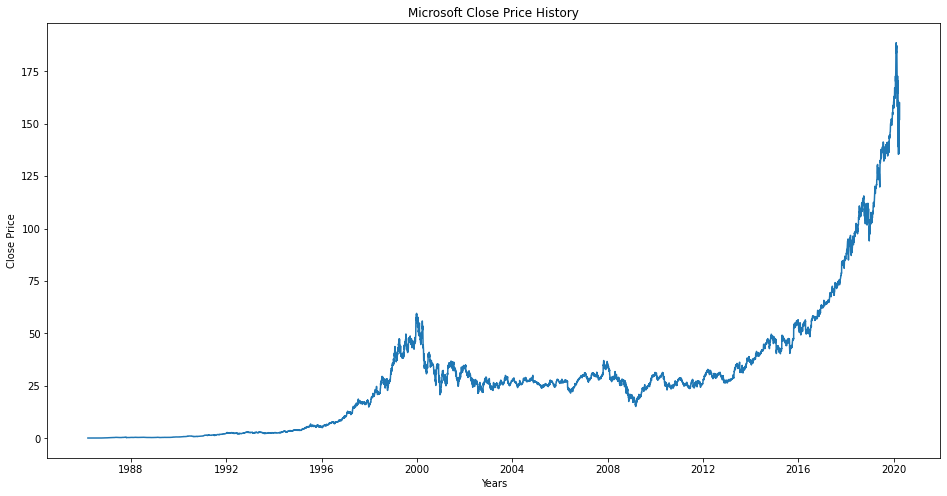

In [81]:
# apple
df_aapl['Date'] = pd.to_datetime(df_aapl.Date,format='%Y-%m-%d')
df_aapl.index = df_aapl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_aapl['Close'])
plt.title("Apple Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# google
df_ggl['Date'] = pd.to_datetime(df_ggl.Date,format='%Y-%m-%d')
df_ggl.index = df_ggl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_ggl['Close'])
plt.title("Google Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# microsoft
df_msft['Date'] = pd.to_datetime(df_msft.Date,format='%Y-%m-%d')
df_msft.index = df_msft['Date']
plt.figure(figsize=(16,8))
plt.plot(df_msft['Close'])
plt.title("Microsoft Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

In [82]:
# Remove data where price stagnant
df_aapl = df_aapl[(df_aapl['Date'] >= '2005-01-01')]
df_msft = df_msft[(df_msft['Date'] >= '1998-01-01')]

In [83]:
def train_test(X, y, movement):
    train_size = round(len(X)*0.7)
    X_train, X_test, y_train, y_test, movement =  X[:train_size], X[train_size:],  y[:train_size], y[train_size:], movement[train_size:]  
    return X_train, y_train, X_test, y_test, movement

In [84]:
def lags(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(np.array(seq_x))
        y.append(np.array(seq_y))
    movement = [(1 if y[i] > y[i-1] else 0) for i in range(1, len(y))]
    return np.array(X), np.array(y), movement

In [85]:
scaler_volumeind = MinMaxScaler(feature_range=(0, 1))
scaler_closeind = MinMaxScaler(feature_range=(0, 1))
scaler_closedep = MinMaxScaler(feature_range=(0, 1))
def pre_process(df_ori, avg, n_steps):
    df = df_ori.copy(deep=True)
    if avg == "weekly":
        df = df.resample('W').mean()
    elif avg == "monthly":
        df = df.resample('M').mean()
    close_X = np.array(df["Close"])[:-1]
    close_X = close_X.reshape((len(close_X), 1))
    volume_X = np.array(df["Volume"])[:-1]
    volume_X = volume_X.reshape((len(volume_X), 1))
    close_y = np.array(df["Close"].shift(-1))[:-1]
    close_y = close_y.reshape((len(close_y), 1))
    
    close_X = scaler_closeind.fit_transform(close_X)
    volume_X = scaler_volumeind.fit_transform(volume_X)
    close_y = scaler_closedep.fit_transform(close_y)

    dataset = np.array(hstack((close_X, volume_X, close_y)))
    X, y, movement = lags(dataset, n_steps)
    X_train, y_train, X_test, y_test, movement = train_test(X, y, movement)
    
    return X_train, y_train, X_test, y_test, movement

In [86]:
# pre-process data: example

def training_data(avg, n_steps):
    X = list()
    y = list()
    for data in [df_aapl, df_msft, df_ggl]:
        X_train, y_train, X_test, y_test, movement = pre_process(data, avg, n_steps)
        X.extend(X_train)
        y.extend(y_train)
    return np.array(X), np.array(y)


In [87]:
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [90]:
# build model
seed = 7
np.random.seed(seed)

def build_lstm(neurons_input = 1, neurons_hidden=1, n_steps=10, n_features=2, dropout=0):
    model = Sequential()
    model.add(LSTM(neurons_input, 
                   activation='relu', 
                   return_sequences=True, 
                   input_shape=(n_steps, n_features),
                   dropout=dropout))
    model.add(LSTM(neurons_hidden, 
                   activation='relu',
                   dropout=dropout))
    model.add(Dense(1,  activation='relu'))
    model.compile(optimizer='adam', loss='mse')
    return model
              
model = KerasRegressor(model=build_lstm, n_steps=10, neurons_input=1, 
                       neurons_hidden=1, dropout=0, verbose=0, 
                       batch_size=2500, epochs=30)

In [92]:
# tune epochs and batch size
param_grid = {
            'batch_size':   [1500, 2500, 5000],
            'epochs':   [10, 30, 50]}
X_train, y_train = training_data("weekly", 10)
cv = TimeSeriesSplit(n_splits=5).split(X_train)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: -3.685862 using {'batch_size': 2500, 'epochs': 30}


In [93]:
# tune neurons, drop out
param_grid = {
            'neurons_input':   [20, 30, 50, 100, 150],
            'neurons_hidden':   [20, 30, 50, 100, 150],
            "dropout": [0, 0.2, 0.35, 0.5]}
X_train, y_train = training_data("weekly", 10)
cv = TimeSeriesSplit(n_splits=5).split(X_train)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: -0.741817 using {'dropout': 0.5, 'neurons_hidden': 150, 'neurons_input': 150}


In [113]:
test_lst= []
pred_lst = []

for lag in [10, 15, 20, 25]:
    for avg in ["daily", "weekly", "monthly"]:
        model = Sequential()
        model.add(LSTM(150, 
                       activation='relu', 
                       return_sequences=True, 
                       input_shape=(lag, 2),
                       dropout=0.5))
        model.add(LSTM(150, 
                       activation='relu',
                       dropout=0.5))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        X_train, y_train = training_data(avg, lag)
        model.fit(X_train, y_train, batch_size=2500, epochs=30, verbose = 0)

        for df in ["Apple", "Microsoft", "Google"]:
            print(f"{df} - lag: {lag} - {avg}")
            if df == "Apple":
                    df = df_aapl
            elif df == "Microsoft":
                df = df_msft
            else:
                df = df_ggl
            X_train, y_train, X_test, y_test, movement = pre_process(df, avg, lag)
            y_pred = model.predict(X_test, verbose=0)
            y_pred = scaler_closedep.inverse_transform(y_pred)
            y_test = y_test.reshape(-1, 1)
            y_test = scaler_closedep.inverse_transform(y_test)
            
            temp_test = y_test.copy()
            temp_pred = y_pred.copy()
            test_lst.append(temp_test)
            pred_lst.append(temp_pred)
            
            mse = mean_squared_error(y_test, y_pred)
            print('Test RMSE: %.3f (%.3f%%)' % (math.sqrt(mse), mean_absolute_percentage_error(y_test, y_pred)))
            movement_pred = [(1 if y_pred[i] > y_pred[i-1] else 0) for i in range(1, len(y_pred))]
            print('Evaluation Metrics:')
            print(confusion_matrix(movement, movement_pred))
            print('Precision: %.3f' % precision_score(movement, movement_pred))
            print('Recall: %.3f' % recall_score(movement, movement_pred))
            print('Accuracy: %.3f' % accuracy_score(movement, movement_pred))
            print('F1-score: %.3f\n' % f1_score(movement, movement_pred))

Apple - lag: 10 - daily
Test RMSE: 85.256 (0.480%)
Evaluation Metrics:
[[216 322]
 [206 403]]
Precision: 0.556
Recall: 0.662
Accuracy: 0.540
F1-score: 0.604

Microsoft - lag: 10 - daily
Test RMSE: 35.465 (0.377%)
Evaluation Metrics:
[[263 520]
 [337 555]]
Precision: 0.516
Recall: 0.622
Accuracy: 0.488
F1-score: 0.564

Google - lag: 10 - daily
Test RMSE: 482.591 (0.470%)
Evaluation Metrics:
[[210 343]
 [265 358]]
Precision: 0.511
Recall: 0.575
Accuracy: 0.483
F1-score: 0.541

Apple - lag: 10 - weekly
Test RMSE: 32.884 (0.138%)
Evaluation Metrics:
[[ 30  61]
 [ 40 104]]
Precision: 0.630
Recall: 0.722
Accuracy: 0.570
F1-score: 0.673

Microsoft - lag: 10 - weekly
Test RMSE: 14.529 (0.103%)
Evaluation Metrics:
[[ 45  89]
 [ 58 153]]
Precision: 0.632
Recall: 0.725
Accuracy: 0.574
F1-score: 0.675

Google - lag: 10 - weekly
Test RMSE: 182.546 (0.162%)
Evaluation Metrics:
[[34 65]
 [47 95]]
Precision: 0.594
Recall: 0.669
Accuracy: 0.535
F1-score: 0.629

Apple - lag: 10 - monthly
Test RMSE: 46.7

In [97]:
# plt.figure(figsize=(16,8))
#             plt.plot(y_test)
#             plt.plot(y_pred)
import math
math.sqrt(4)
        


2.0

In [112]:
print("%.3f    %.3f %%" % (0.9876, 0.8775))

0.988    0.877 %
